r n b q k b n r
p p p p p p p p
. . . . . . . .
. . . . . . . .
. . . . . . . .
. . . . . . . .
P P P P P P P P
R N B Q K B N R


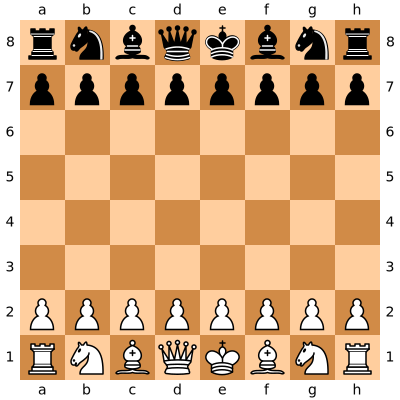

In [1]:
import sklearn.ensemble
import chess_bot
from chess_bot.utils import play_game
from chess_bot import bots

board = chess_bot.Board()

print(board)
board

### Have the rando bot play itsself until black and white win at least 10 times each ###

black won
white won
black won
black won
black won
white won
black won
white won
white won
white won
white won
black won
black won
white won
black won
black won
black won
white won
white won
black won
white won
black won
white won


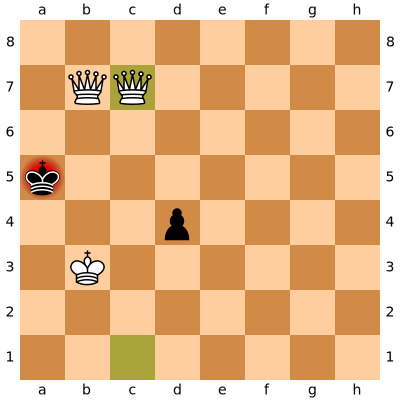

In [5]:


n_winning_games = 10

board_list = list()

black_won = 0
white_won = 0

p1 = bots.RandoBot()

while not (black_won > n_winning_games and white_won > n_winning_games):

    board = chess_bot.Board()
    final_board, turn = play_game(board, p1, p1)

#     print(turn)
    winner = final_board.who_won()
    
    if winner == 0:
        black_won += 1
        print('black won')
        
        board_list.append(final_board)
        
    elif winner == 1:
        white_won += 1
        print('white won')
    
        board_list.append(final_board)
    
final_board

### Have a random forest bot learn from the above games ###

In [3]:
p_bot = bots.SKLearnBot(sklearn.ensemble.RandomForestClassifier(n_estimators=100))
p_bot.train_from_board(board_list)

### Let the RF bot play itsself a few times ###

In [4]:
# while len(train_board_list) < 500:
p_bot.state = 'wexploit'

tot_wins = 10
n_wins = 0

while n_wins < tot_wins:
    board = chess_bot.Board()
    final_board, turn = play_game(board, p_bot, p_bot)

    winner = final_board.who_won()
    
    print(turn)
    print(winner)

    if winner != 2:
        n_wins += 1
        board_list.append(final_board)
        p_bot.train_from_board(board_list)

final_board

596
2
287
2
266
2
106
0
357
2
444
2
352
2
463
2
437
2
135
1
561
2
478
2
488
2
411
2
732
2
543
2
466
2
514
2
260
0
517
2


KeyboardInterrupt: 

### See if it can beat the rando bot ###

In [ ]:
p1 = RandoBot()

p_bot.state = 'exploit'

board_list = list()

black_won = 0
white_won = 0

n_games = 0
while n_games < 50:

    board = chess_bot.Board()
    final_board, turn = play_game(board, p1, p_bot)

    print(turn)
    winner = final_board.who_won()
    
    if winner == 1:
        white_won += 1
        board_list.append(final_board)
        print('white won')
    elif winner == 0:
        black_won += 1
        board_list.append(final_board)
        print('black won')

    n_games +=1
    
final_board